<a href="https://colab.research.google.com/github/alxkzncoff/skillfactory_rds6_car_price_prediction_ml_dl/blob/main/model/multi_input_nlp_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INSATLL

In [1]:
!pip install -q tensorflow==2.3
!pip install PyDrive
!mkdir work_dir

!pip install pymystem3
!pip install imgaug==0.2.5
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

mkdir: cannot create directory ‘work_dir’: File exists
  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-lc17f9db
  Running command git clone -q https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-lc17f9db
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-cp36-none-any.whl size=28165 sha256=f4df0ca0ea497e59f15223510f46258be7625ea2ca4af9c29bab3ba1e7595fb6
  Stored in directory: /tmp/pip-ephem-wheel-cache-h7wb_fc8/wheels/d9/10/55/6fca35a4072f87d694876d56ece64db3846cf45e1da1c381fe
Successfully built ImageDataAugmentor


# DEFINE

In [2]:
DATA_PATH                           = '/content/work_dir'
RANDOM_SEED                         = 42

# IMPORT

In [3]:
# Data access
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# General
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import sys
import PIL
import cv2
import re
import keras
from zipfile import ZipFile

# NLP
import nltk
nltk.download('punkt')
nltk.download("stopwords")

from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
import codecs

# ML
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

# KERAS
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils.vis_utils import plot_model

# images
from ImageDataAugmentor.image_data_augmentor import *
import albumentations as alb

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Чтобы Mystem библиотека работал корректно
mystem = Mystem() 
!wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
!tar -xvf mystem-3.0-linux3.1-64bit.tar.gz
!cp mystem /root/.local/bin/mystem

--2020-11-15 18:26:03--  http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving download.cdn.yandex.net (download.cdn.yandex.net)... 5.45.205.241, 5.45.205.243, 5.45.205.244, ...
Connecting to download.cdn.yandex.net (download.cdn.yandex.net)|5.45.205.241|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://cache-mskm909.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz [following]
--2020-11-15 18:26:03--  http://cache-mskm909.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving cache-mskm909.cdn.yandex.net (cache-mskm909.cdn.yandex.net)... 5.45.220.19, 2a02:6b8:0:2002::1a
Connecting to cache-mskm909.cdn.yandex.net (cache-mskm909.cdn.yandex.net)|5.45.220.19|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16457938 (16M) [application/octet-stream]
Saving to: ‘mystem-3.0-linux3.1-64bit.tar.gz.1’

mystem-3.0-linux3.1 100%[===================>] 

# DOWNLOAD DATA

In [5]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
# Download clear_train.csv from google drive to Colab VM.
downloaded = drive.CreateFile({'id':"1-3kiZxEddvuNFoRTfMA6cA8bu7LjP2b3"}) # откуда берем файл
downloaded.GetContentFile(DATA_PATH+'/clear_train.csv') # куда сохраняем файл в вирутальной машине колаба

# Download clear_test.csv from google drive to Colab VM.
downloaded = drive.CreateFile({'id':"1-0yG59TcpJoDSeOclid1z-nc1Fh3yud2"})
downloaded.GetContentFile(DATA_PATH+'/clear_test.csv')

# Download sample_submission from google drive to Colab VM.
downloaded = drive.CreateFile({'id':"1Edwuioev6uEyeXuCQuloPNQ70V5-3HZG"})
downloaded.GetContentFile(DATA_PATH+'/sample_submission.csv')

# Download image.zip from google drive to Colab VM.
downloaded = drive.CreateFile({'id':"1T0TxiIRNusgeKt4yu5ukniVGtgj0F2F7"})
downloaded.GetContentFile(DATA_PATH+'/img.zip')

In [7]:
# Распакуем изображения на виртуальной машине, для быстрого доступа.
with ZipFile(DATA_PATH+'/img.zip', 'r') as zipObj:
   zipObj.extractall(DATA_PATH)

Чтобы не забыть:

`drive.CreateFile({'id':"file ID"})`, где file ID - это ID который можно найти в ссылке на файл. Например для сслыки **https://drive.google.com/file/d/1-3kiZxEddvuNFoRTfMA6cA8bu7LjP2b3/view?usp=sharing** ID будет `1-3kiZxEddvuNFoRTfMA6cA8bu7LjP2b3`.

Данные с которыми будешь работать лучше сразу сохранять в ВМ колаба, чтобы обработка происходила быстрее, особенно когда работаем с изображениями (строим нейроки для Computer Vision).

Как сохранять файлы хорошо расписано [тут](https://buomsoo-kim.github.io/colab/2018/04/16/Importing-files-from-Google-Drive-in-Google-Colab.md/) и [тут](https://stackoverflow.com/questions/48376580/google-colab-how-to-read-data-from-my-google-drive).

In [8]:
train = pd.read_csv(DATA_PATH+'/clear_train.csv')
test = pd.read_csv(DATA_PATH+'/clear_test.csv')
sample_submission = pd.read_csv(DATA_PATH+'/sample_submission.csv')
text_df = pd.concat([train.description, test.description])
text_df.reset_index(drop=True, inplace=True)

# PREPARETION

In [9]:
def data_prep(TRAIN_DF, TEST_DF):

  # ################## Concat data ####################
  df = pd.concat([TRAIN_DF, TEST_DF])

  # ################## Tag data #####################
  df.price.fillna(0, inplace=True)
  df['sample'] = df.price.apply(lambda x:0 if x == 0 else 1)

  # ################## Prepare numeric data (Logarithm) ####################
  df.engine_displacement = df.engine_displacement.max() - np.log(df.engine_displacement)
  df.engine_power = df.engine_power.max() - np.log(df.engine_power)
  # df.model_date = df.model_date.max() - np.log(df.model_date)
  # df.production_date = df.production_date.max() - np.log(df.production_date)
  # df.days_in_use = df.days_in_use.max() - np.log(df.days_in_use)

  categorical_features = ['body', 'brand', 'color', 'fuel', 'model_info', 'name',  'num_of_doors',  'transmission', 'owners', 'vehicle_title', 'drive_type']
  numerical_features = ['engine_displacement', 'engine_power', 'mileage', 'model_date', 'production_date', 'tax', 'days_in_use']

  # ############################## Label Encoding #####################################
  for column in categorical_features:
      df[column] = df[column].astype('category').cat.codes
  
  # ############################### One Hot encoding ###################################
  df = pd.get_dummies(df, columns=categorical_features, dummy_na=False)

  # ############################### Normalization ######################################
  MMS = MinMaxScaler()

  MMS.fit(df[numerical_features])
  df[numerical_features] = MMS.transform(df[numerical_features])

  return df

In [10]:
df = data_prep(train, test)
df.reset_index(drop=True, inplace=True)
df

,description,engine_displacement,engine_power,mileage,model_date,price,production_date,sell_id,tax,days_in_use,sample,body_0,body_1,body_2,body_3,body_4,body_5,body_6,body_7,body_8,body_9,body_10,body_11,body_12,brand_0,brand_1,brand_2,color_0,color_1,color_2,color_3,color_4,color_5,color_6,color_7,color_8,color_9,color_10,color_11,color_12,...,name_337,name_338,name_339,name_340,name_341,name_342,name_343,name_344,name_345,name_346,name_347,name_348,name_349,name_350,name_351,name_352,name_353,name_354,name_355,name_356,name_357,name_358,name_359,num_of_doors_0,num_of_doors_1,num_of_doors_2,num_of_doors_3,transmission_0,transmission_1,transmission_2,transmission_3,owners_0,owners_1,owners_2,owners_3,vehicle_title_0,vehicle_title_1,drive_type_0,drive_type_1,drive_type_2
0,Авто на бодром ходу. Все работает отлично. П...,0.328812,0.423210,0.244999,0.750000,599000.0,0.657895,1099980990,0.383285,0.342100,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1
1,"Продажа от собственника, второй владелец, ПТС ...",0.357585,0.552008,0.182999,0.833333,850000.0,0.763158,1095836906,0.118732,0.236833,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0
2,Внимание! Только для клиентов AVILON Автомобил...,0.264526,0.370477,0.122732,0.791667,1325000.0,0.815789,1100195530,0.432277,0.184163,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1
3,В комплекте зимние колёса. 27.07.2020 Замена п...,0.497904,0.608045,0.150999,0.833333,815000.0,0.763158,1099880662,0.077810,0.236833,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,1,0
4,"Отличный авто, 2011 года выпуска, кроме передн...",0.541843,0.660777,0.139999,0.750000,810000.0,0.763158,1083244610,0.060519,0.236833,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8348,Продаётся любимица семьи. Автомобилем неактивн...,0.497904,0.598204,0.075999,0.833333,0.0,0.789474,1099414488,0.079731,0.210534,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,1,0,0
8349,"В продаже автомобиль от компании АО ABTODOM, о...",0.328812,0.522291,0.120380,0.875000,0.0,0.921053,1099277058,0.127474,0.078896,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,1
8350,Машина в идеальном техническом состоянии. Обсл...,0.646649,0.689672,0.025789,0.895833,0.0,0.894737,1098773964,0.041787,0.105267,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0
8351,Автомобиль приобретался новым у дилера Avilon ...,0.497904,0.598204,0.103999,0.791667,0.0,0.815789,1098835932,0.079731,0.184163,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,1,0,0


In [11]:
text_df

0       Авто на бодром ходу.  Все работает отлично.  П...
1       Продажа от собственника, второй владелец, ПТС ...
2       Внимание! Только для клиентов AVILON Автомобил...
3       В комплекте зимние колёса. 27.07.2020 Замена п...
4       Отличный авто, 2011 года выпуска, кроме передн...
                              ...                        
8348    Продаётся любимица семьи. Автомобилем неактивн...
8349    В продаже автомобиль от компании АО ABTODOM, о...
8350    Машина в идеальном техническом состоянии. Обсл...
8351    Автомобиль приобретался новым у дилера Avilon ...
8352    ID: 38887\nКомплектация-Comfort\nГод выпуска в...
Name: description, Length: 8353, dtype: object

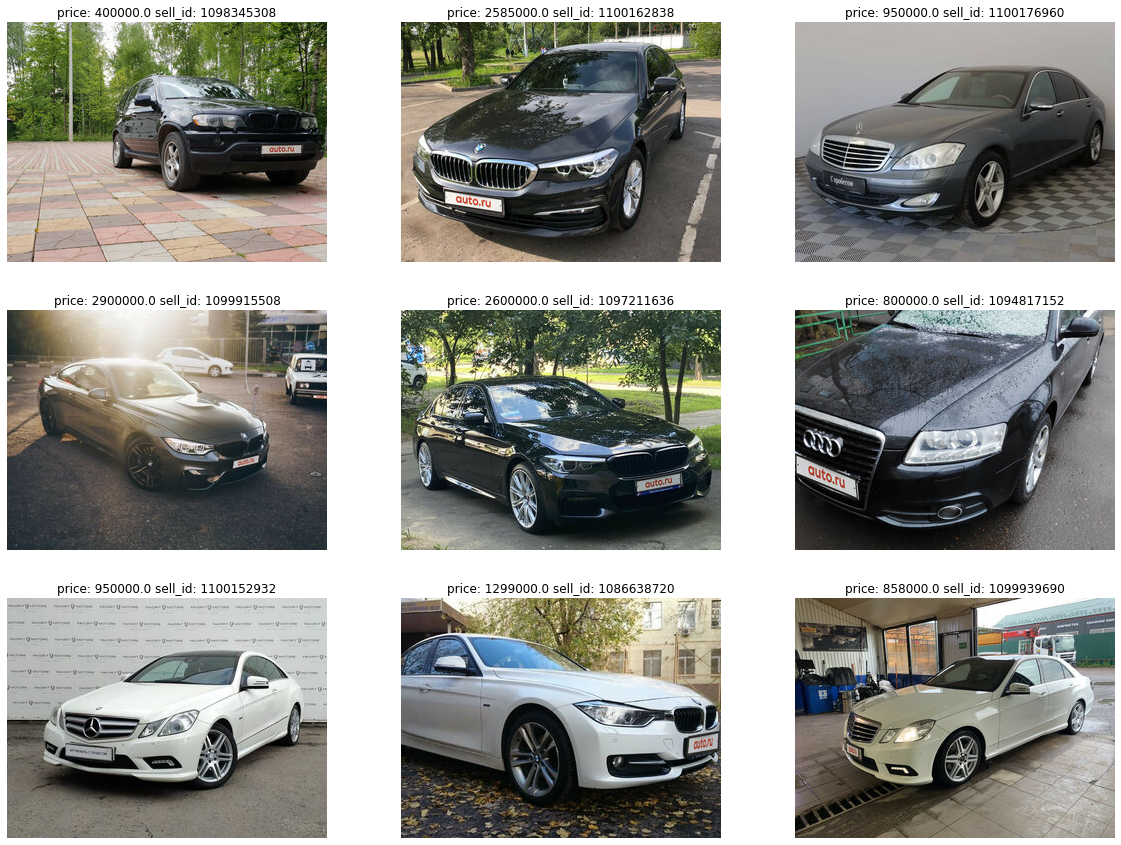

In [12]:
plt.figure(figsize = (20,15))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_PATH+'/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]) + ' sell_id: ' + str(path))
    plt.axis('off')
plt.show()

# TO DO LIST

1. Удалить все нерелевантные символы (например, любые символы, не относящиеся к цифро-буквенным).
2. Токенизировать текст, разделив его на индивидуальные слова.
3. Удалить нерелевантные слова — например, упоминания в Twitter или URL-ы.
4. Перевести все символы в нижний регистр для того, чтобы слова «привет», «Привет» и «ПРИВЕТ» считались одним и тем же словом.
5. Рассмотрите возможность совмещения слов, написанных с ошибками, или имеющих альтернативное написание (например, «круто»/«круть»/ «круууто»)
6. Рассмотрите возможность проведения лемматизации, т. е. сведения различных форм одного слова к словарной форме (например, «машина» вместо «машиной», «на машине», «машинах» и пр.)

# TEXT PREPARING

In [13]:
# Создаем леммитайзер и список стоп-слов
mystem = Mystem() 
russian_stopwords = stopwords.words("russian")

# Функция для лемматизации и удалении стоп-слов
def preprocess_text(text):

    tokens = mystem.lemmatize(text.lower())

    # Убираем стоп-слова
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " " \
              and token.strip() not in punctuation]

    # Оставляем стоп-слова
    # tokens = [token for token in tokens if token != " " \
    #           and token.strip() not in punctuation]
    
    text = " ".join(tokens)

    nums_and_chars = ' '.join(re.findall(r'\w+',text))
    chars = ''.join(re.findall(r'\D+',nums_and_chars))
    only_chars = re.sub(r'[!"#$%&\'()*+,-./:;?@[\\]^_`{|}~]', '', chars)
    final_text = re.sub(r'[a-z]', '', only_chars)
    
    return final_text

In [14]:
print(f'Пример текста до обработки:\n{text_df.iloc[0]}\n')

text_df = text_df.apply(preprocess_text)

print(f'Пример текста после обработки:\n{text_df.iloc[0]}')

Пример текста до обработки:
Авто на бодром ходу.  Все работает отлично.  По электрике,ходовой.,АКПП ДВС нареканий нет..,   Масло не ест. .!!!Салон ухожен. На запчасти денег не жалел. Жидкости все поменял. Крашена одна дверь левая задняя. Штрафов и ограничений нет. ..!  Торг при осмотре. Возможен обмен на внедорожник или коммерческий транспорт. 

Пример текста после обработки:
авто бодрый ход работать отлично электрика ходовой акпп двс нарекание масло салон уходить запчасть деньги жалеть жидкость поменять красить дверь левый задний штраф ограничение торг осмотр возможный обмен внедорожник коммерческий транспорт


# SPLIT

In [15]:
X = df.query('sample==1').drop(columns=['description', 'price', 'sample', 'sell_id'])
y = df.query('sample==1').price.values
sub = df.query('sample==0').drop(columns=['description', 'price', 'sample', 'sell_id'])

# ############ Split #################
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, shuffle=True, random_state=RANDOM_SEED)

text_train = text_df.iloc[X_train.index]
text_test = text_df.iloc[X_test.index]
text_sub = text_df.iloc[sub.index]

# TOKENIZE

## Bag of words with tfidf 2-grams

In [16]:
  MAX_WORDS=100000

In [17]:
def bow_tfidf_2_grams(text, train_df, test_df, sub_df):

  tfidf_vectorizer=TfidfVectorizer(analyzer='word', ngram_range=(2,2), min_df=60, max_features=MAX_WORDS, use_idf=True, smooth_idf=True)
  tfidf_vectorizer_vectors=tfidf_vectorizer.fit(text)

  train_tfidf = tfidf_vectorizer.transform(train_df)
  test_tfidf = tfidf_vectorizer.transform(test_df)
  text_sub_tfidf = tfidf_vectorizer.transform(sub_df)

  print(train_tfidf.shape, test_tfidf.shape, text_sub_tfidf.shape, )

  text_df_transform = tfidf_vectorizer.transform(text_df)

  train=train_tfidf.todense()
  test=test_tfidf.todense()
  sub=text_sub_tfidf.todense()

  return train, test, sub, text_df_transform, tfidf_vectorizer

In [18]:
train_tfidf, test_tfidf, text_sub_tfidf, text, vocabulary = bow_tfidf_2_grams(text_df, text_train, text_test, text_sub)
vocabulary_size = len(vocabulary.get_feature_names())

print(f'\nПример токенов:\n{vocabulary.get_feature_names()[500:520]}')
print(f'\nРазмер словаря: {vocabulary_size}')

(6013, 1507) (669, 1507) (1671, 1507)

Пример токенов:
['ключ комплект', 'ключ регулировка', 'ключ электрорегулировка', 'км автомобиль', 'км кузов', 'км назад', 'км пробег', 'книжка свидетельство', 'кнопка система', 'коврик знак', 'код автомобиль', 'код кожаный', 'кожа напп', 'кожа рычаг', 'кожа черный', 'кожаный обивка', 'кожаный рулевой', 'кожаный руль', 'кожаный салон', 'колено подушка']

Размер словаря: 1507


# IMAGE

In [19]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(df['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_PATH + '/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(sub.index)

images shape (6013, 240, 320, 3) dtype uint8
images shape (669, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


In [20]:
augmentation = alb.Compose([
    alb.OneOf([                                  # выбираем вариант разворота изображения
        # alb.HorizontalFlip(),
        # alb.Transpose(),
        alb.Rotate(limit=10),
        # alb.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, interpolation=1, border_mode=4, approximate=False)
    ], p = 0.6),
    alb.OneOf([
        # alb.ToSepia(),
        alb.ToGray(),              
    ], p = 0.3),
    alb.OneOf([
        alb.ChannelShuffle(),
        # alb.ChannelDropout()        
    ], p=0.3),
    alb.OneOf([                                 # выбираем один из вариантов размытия изображения
        alb.MotionBlur(blur_limit=3),
        alb.MedianBlur(blur_limit=3),
        alb.Blur(blur_limit=3)        
    ], p = 0.3),
    alb.OneOf([
        alb.OpticalDistortion(p=0.3),
        alb.GridDistortion(p=0.1),
        alb.IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    alb.OneOf([
        alb.IAAAdditiveGaussianNoise(),         # выбираем один из видов шумов
        alb.GaussNoise(),
        # alb.ISONoise()
    ], p = 0.3),
    alb.JpegCompression(quality_lower=12, quality_upper=100, p=0.3),   # компрессия
    alb.RandomBrightnessContrast(0.2, 0.2, p=0.3)
])

plt.figure(figsize = (20,15))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [21]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, train_tfidf, y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, test_tfidf, y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, sub, text_sub_tfidf, y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

# MODEL

In [22]:
# MAPE
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [23]:
def number_of_nodes(layers, input_shape, output_shape):

  # #############################################################
  # layers - количествой слоев в нейронной сети
  # input_shape - количество признаков нейронной сети на входе
  # output_shape - необходимое количество нейронов выходного слоя
  # #############################################################

  for num_of_layers in range(layers):
    num_of_tabular_neurons = int(2/3 * (input_shape * output_shape))
    input_shape = num_of_tabular_neurons
    print(f'Количесто нейронов {num_of_layers+1} слоя: {num_of_tabular_neurons}')

## Со стоп-словами

## Без стоп-слов

In [24]:
print('Tabular NN:')
number_of_nodes(2, 542, 1)
print('')
print('NLP NN:')
number_of_nodes(4, 1507, 1)
print('')
print('Concationation:')
number_of_nodes(3, 2222, 1)

Tabular NN:
Количесто нейронов 1 слоя: 361
Количесто нейронов 2 слоя: 240

NLP NN:
Количесто нейронов 1 слоя: 1004
Количесто нейронов 2 слоя: 669
Количесто нейронов 3 слоя: 446
Количесто нейронов 4 слоя: 297

Concationation:
Количесто нейронов 1 слоя: 1481
Количесто нейронов 2 слоя: 987
Количесто нейронов 3 слоя: 658


In [25]:
def build_model(LR, EPOCHS, OPTIMIZER_TYPE):

  # ################## Image model ####################
  efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB4(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
  efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

  # ################## NLP model ####################
  model_nlp = Sequential()
  model_nlp.add(L.Input(shape=vocabulary_size, name="seq_description"))
  model_nlp.add(L.Embedding(vocabulary_size+1, 1004,))
  model_nlp.add(L.LSTM(669,))
  model_nlp.add(L.Dropout(0.2))
  model_nlp.add(L.Dense(446,))
  model_nlp.add(L.Activation('relu'))

  # ################# DENSE model ####################
  model_mlp = Sequential()
  model_mlp.add(L.Dense(361, input_dim=X_train.shape[1], activation="relu",))
  model_mlp.add(L.Dropout(0.2))
  model_mlp.add(L.Dense(240, activation="relu",))

  # ################# Concatenate models ######################
  combinedInput = L.concatenate([efficientnet_output, model_mlp.output, model_nlp.output])
  head = L.Dense(256, activation="relu")(combinedInput)
  head = L.Dense(1,)(head)

  model = Model(inputs=[efficientnet_model.input, model_mlp.input, model_nlp.input], outputs=head)
  display(model.summary())

  # ################# Optimizer #######################
  if OPTIMIZER_TYPE == 'Adam':
    optimizer = tf.keras.optimizers.Adam(LR)
  elif OPTIMIZER_TYPE == 'Adamax':
    optimizer = tf.keras.optimizers.Adamax(LR)

  model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

  # ################# Checkpoints ######################
  checkpoint = ModelCheckpoint(DATA_PATH+'/best_model.hdf5', monitor='val_MAPE', verbose=1, save_best_only=True, mode='min')
  earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
  callbacks_list = [checkpoint, earlystop]

  # ######################## Fit model ##############################
  history = model.fit(train_dataset.batch(24),
                      epochs=EPOCHS,
                      validation_data = test_dataset.batch(24),
                      callbacks=callbacks_list,
                      verbose=1
                    )

  # ######################## Show results ###########################
  plt.figure(figsize=(15,10))
  plt.title('Loss')
  plt.plot(history.history['MAPE'], label='train')
  plt.plot(history.history['val_MAPE'], label='test')
  plt.legend()
  plt.grid()
  plt.show()

  # ######################## Saving best model #####################
  model.load_weights(DATA_PATH+'/best_model.hdf5')
  model.save(DATA_PATH+'/nn_mlp_nlp.hdf5')

  test_predict_nn3 = model.predict(test_dataset.batch(24))
  print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

  return model, checkpoint, earlystop, callbacks_list, history, test_predict_nn3

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

None

Epoch 1/100
251/251 [==============================] - ETA: 0s - loss: 50.9808 - MAPE: 50.9808
Epoch 00001: val_MAPE improved from inf to 109.48704, saving model to /content/work_dir/best_model.hdf5
251/251 [==============================] - 256s 1s/step - loss: 50.9808 - MAPE: 50.9808 - val_loss: 109.4871 - val_MAPE: 109.4870
Epoch 2/100
251/251 [==============================] - ETA: 0s - loss: 31.3785 - MAPE: 31.3785
Epoch 00002: val_MAPE improved from 109.48704 to 27.23708, saving model to /content/work_dir/best_model.hdf5
251/251 [==============================] - 251s 1s/step - loss: 31.3785 - MAPE: 31.3785 - val_loss: 27.2371 - val_MAPE: 27.2371
Epoch 3/100
251/251 [==============================] - ETA: 0s - loss: 24.9935 - MAPE: 24.9935
Epoch 00003: val_MAPE improved from 27.23708 to 22.06714, saving model to /content/work_dir/best_model.hdf5
251/251 [==============================] - 252s 1s/step - loss: 24.9935 - MAPE: 24.9935 - val_loss: 22.0671 - val_MAPE: 22.0671
Epoch 4/

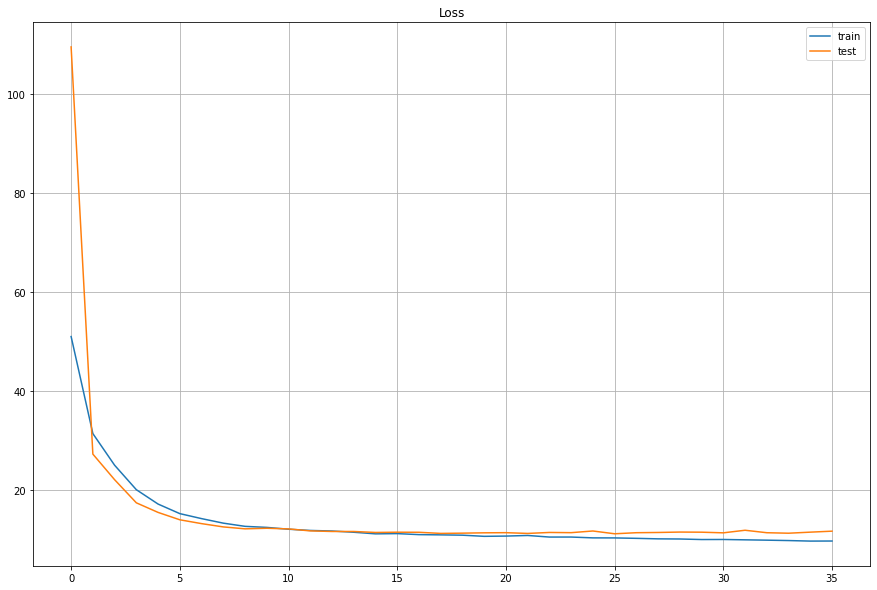

TEST mape: 11.14%


In [26]:
model, checkpoint, earlystop, callbacks_list, history, test_predict_nn3 = build_model(LR=0.01, EPOCHS=100, OPTIMIZER_TYPE='Adamax')

# PREDICT

In [28]:
predict_submission = model.predict(sub_dataset.batch(24))

sample_submission['price'] = predict_submission
sample_submission.to_csv(DATA_PATH+f'/sub_nn3_{round((mape(y_test, test_predict_nn3[:,0])*100),2)}.csv'.replace('.', '_', 1), index=False)
display(sample_submission.head(10))

,sell_id,price
0,1099427284,3.725035e+05
1,1096405886,2.637952e+06
2,1100195294,6.374869e+05
3,1099827282,5.087313e+05
4,1100076198,2.705159e+06
5,1090159352,3.375389e+06
6,1098987386,1.584497e+06
7,1098639040,1.563255e+06
8,1099933039,1.140446e+06
9,1099565572,5.292988e+05
